In [10]:
import numpy as n
from astropy import constants
from astropy.coordinates import SkyCoord
from astroplan import Observer
from astroplan import FixedTarget
from astropy.time import Time
import astropy.units as u
import configparser
import matplotlib.pyplot as plt

#ETC modules
from sky_and_telescope_data import sky_emission
from sky_and_telescope_data import sky_transmission
import spectrum_resolution

In [11]:
# constants
kb = constants.k_B.value #[J/K]
c = constants.c.value    #[m/s]
h = constants.h.value    #[J/s]   
e_charge = constants.e   #[Coloumbs]
microns2m = 1e-6         #[microns/meters]
deg2rad = 0.0174533      #[deg/radians]
sterr = 1 / 206265**2    #[rad^2 / arcsec^2]

In [12]:
def B_lam(T,lams):

    #Planck's Law

    ### inputs ####
    #T - temperature [Kelvin]
    #lams - microns

    ### output ####
    ## B_lam ### [W/ m^2 / m]

    B_lam_a = (2 * h * c**2) / (lams * microns2m) **5
    B_lam_b = n.exp( h * c / (lams * microns2m) / kb / T ) - 1

    B_lam = B_lam_a / B_lam_b

    return B_lam


In [13]:
# constants
kb = constants.k_B.value #[J/K]
c = constants.c.value    #[m/s]
h = constants.h.value    #[J/s]   
e_charge = constants.e   #[Coloumbs]
microns2m = 1e-6         #[microns/meters]
deg2rad = 0.0174533

#telescope parameters
aperture = 30   #meter               
distance = 40.9 #pc
exp_time = 10   #seconds
duration = 1    #hours

observing_mode = 'IFS_low_H'

image_number = int(duration * 60 * 60 / exp_time)
image_numbers = n.arange(image_number)
print('image number:', str(image_number) + ' # exposures')
print('duration:', str(duration) + ' hours')

image number: 360 # exposures
duration: 1 hours


In [14]:
observer = Observer.at_site('LBT')
target_name = "HR 8799"
ra = '23h07m28.71s'
dec = '21d08m03.31s'

In [15]:
pa1 = 140
pa2 = 60
pa3 = 300
pa4 = 340

In [16]:
coordinates = SkyCoord(ra, dec , frame='icrs')
target_info = FixedTarget(name=target_name, coord=coordinates)

time = Time(['2026-09-07 0:00:00'])
dt = n.arange(0,image_number)* exp_time
times = time + (dt * u.second)
parallactic_angles = observer.parallactic_angle(times, target_info).deg

position_angle1 = pa1 + n.zeros(len(parallactic_angles))
position_angle2 = pa2 + n.zeros(len(parallactic_angles))
position_angle3 = pa3 + n.zeros(len(parallactic_angles))
position_angle4 = pa4 + n.zeros(len(parallactic_angles))

total_angle1 = position_angle1 + parallactic_angles
total_angle2 = position_angle2 + parallactic_angles
total_angle3 = position_angle3 + parallactic_angles
total_angle4 = position_angle4 + parallactic_angles

airmasses = observer.altaz(times, target_info).secz 
airmasses = airmasses.value

good = n.where((airmasses >= 1.) & (airmasses <= 2.06))
bad = n.where((airmasses < 1.) | (airmasses > 2.06))


parallactic_angles = parallactic_angles[good]
airmasses = airmasses[good] 
total_angle1 = total_angle1[good]
total_angle2 = total_angle2[good]
total_angle3 = total_angle3[good]
total_angle4 = total_angle4[good]
image_numbers = image_numbers[good]
dt = dt[good]

In [19]:
observing_mode_info = configparser.ConfigParser()
observing_mode_info.read('instrument_data/observing_modes/tempo_observing_modes.ini')

['instrument_data/observing_modes/tempo_observing_modes.ini']

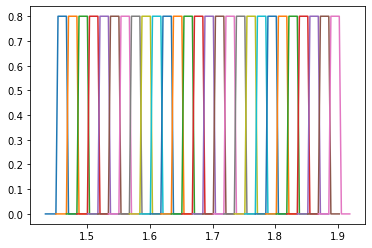

In [20]:
R = float(observing_mode_info[observing_mode]['resolution'])
start_lam = float(observing_mode_info[observing_mode]['wave_min'])
end_lam = float(observing_mode_info[observing_mode]['wave_max'])
plate_scale = (17.9* 1e-3) #[arcseonds/pix]

central_wavelength = (start_lam+end_lam)/2
del_R = central_wavelength/R  #spacing of wavelength element
filter_spacing = n.arange(start_lam, end_lam, del_R)

filter_info = [None] * len(filter_spacing)

plt.figure('Filter/Spacing')

for i, filter_start in enumerate(filter_spacing):
    
    filter_lam = n.arange(filter_start-del_R,filter_start+2*del_R,del_R/5)
    response = n.where( (filter_lam > (filter_start)) & (filter_lam < (filter_start + del_R)) )
    filter_t = n.zeros(filter_lam.shape)
    filter_t[response] = .8
    
    
    plt.plot(filter_lam, filter_t)
    
    filter_info[i] = filter_t, filter_lam
plt.show()

#n.save(save_dir + 'filter_info', filter_info)


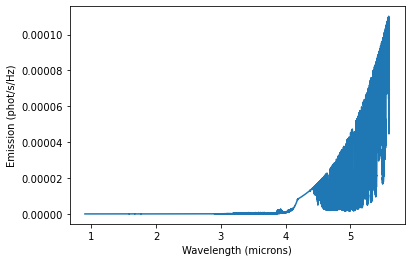

In [32]:
sky_dir = '/Users/zen/projects/TEMPO/TEMPO_github/etc/sky_and_telescope_data/'

sky_flux, sky_lam = sky_emission.sky_emission_JHKLM(1.0, 1.0, sky_dir) #phot/s/nm/arcsec^2/m^2, #angstroms

sky_flux *= n.pi * (aperture**2)                #phot/s/nm/arcsec^2
sky_flux *= plate_scale**2                      #phot/s/nm
sky_flux *= (1./1e-9)  #*(nm/m)       ->        #phot/s/m
sky_flux *= ((sky_lam * 1e-10)**2)/c            #phot/s/Hz

sky_lam /= 10000 #microns

plt.figure('sky')
plt.plot(sky_lam, sky_flux)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Emission (phot/s/Hz)')
plt.show()

In [33]:
#Load Elf Owl model from this directory
elf_owl_base_dir = '/Users/zen/data/models/sonora_elf_owl/spectra/' #change this to yours

teff = 275
gravity = 17.0
metallicity = 0
co_ratio = 0.5
logKzz = 2.0

data_elf_owl = spectrum_resolution.load_elfowl_spectra_from_tar(elf_owl_base_dir, teff, gravity, metallicity, co_ratio, logKzz)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zen/data/models/sonora_elf_owl/spectra/.tar.gz'

In [34]:
#load diamondback model from this directory
diamondback_base_dir = '/Users/zen/data/models/sonora_bobcat_models/spectra/' #change this to yours

teff = 300
gravity = 316
metallicity = 0.5
co_ratio = -0.5
#logKzz = None  #Sonora diamondback does not use Kzz, it has a fsed parameter
fsed = 4

data_sonora_diamondback = spectrum_resolution.load_diamondback_spectrum_from_tar(diamondback_base_dir, teff, gravity, metallicity, co_ratio, logkzz)

AttributeError: module 'spectrum_resolution' has no attribute 'load_diamondback_spectrum_from_tar'

In [ ]:
#load 
madden2020_base_dir = '/Users/zen/data/models/madden2020/spectra/' #change this to yours

#host_star_spectral_type 
#material
#etc

#data_madden2020 = spectrum_resolution.load_madden2020_from_tar(filename,#fill in parameters)

In [15]:
import xarray

In [17]:
teff= '450.0' #K
grav='31.0' # m/s/s
mh='-1.0'
co='0.5' # relative to solar
logkzz='9.0'

base_dir = '/Users/zen/data/models/sonora_elf_owl/spectra/'
filename = 'spectra_logzz_9.0_teff_950.0_grav_562.0_mh_1.0_co_2.5.nc'
ds = xarray.load_dataset(base_dir + filename)


In [20]:
ds['wavelength'].data

array([14.99976075, 14.99951076, 14.99926077, ...,  0.6000215 ,
        0.6000115 ,  0.6000015 ])

In [21]:
ds['flux'].data

array([2.19862412e+09, 2.25277651e+09, 2.29138957e+09, ...,
       1.14941485e+06, 1.14645016e+06, 1.14339050e+06])

In [22]:
ds

<xarray.Dataset>
Dimensions:      (wavelength: 193132, pressure: 91)
Coordinates:
  * wavelength   (wavelength) float64 15.0 15.0 15.0 15.0 ... 0.6 0.6 0.6 0.6
  * pressure     (pressure) float64 0.0001778 0.0002054 ... 66.98 77.38
Data variables: (12/40)
    flux         (wavelength) float64 2.199e+09 2.253e+09 ... 1.143e+06
    temperature  (pressure) float64 400.1 401.3 402.9 ... 2.623e+03 2.708e+03
    e-           (pressure) float64 4.5e-38 4.5e-38 ... 1.564e-07 2.069e-07
    H2           (pressure) float64 0.8216 0.8216 0.8216 ... 0.8223 0.8211
    H            (pressure) float64 9.263e-25 1.049e-24 ... 0.004681 0.006049
    H+           (pressure) float64 4.5e-38 4.5e-38 ... 3.932e-22 2.375e-21
    ...           ...
    OCS          (pressure) float64 3.246e-17 2.915e-17 ... 2.304e-08 2.577e-08
    Li           (pressure) float64 4.5e-38 4.5e-38 ... 2.768e-08 2.758e-08
    LiOH         (pressure) float64 4.5e-38 4.5e-38 ... 1.376e-10 1.303e-10
    LiH          (pressure) float64 4.5e-38 4.5e-38 ... 6.978e-09 7.253e-09
    LiCl         (pressure) float64 4.5e-38 4.5e-38 ... 4.016e-10 2.962e-10
    LiF          (pressure) float64 4.5e-38 4.5e-38 ... 1.376e-11 1.065e-11
Attributes:
    author:         Batalha,Mukherjee
    contact:        natasha.e.batalha@nasa.gov
    code:           {"spectra": "PICASO", "chemistry": "visccher"}
    doi:            ELF OWL Paper
    planet_params:  {"logg": {"value": 562.0, "unit": "m / s2"}, "teff": {"va...